In [1]:
import pandas as pd

from behavioral_analysis.frame_pipeline.reader_classes import Cv2VideoFrameReader, FrameStackReader
from behavioral_analysis.frame_pipeline.processor_classes import FrameReorientedRoiExtractor, TextAnnotatedFramesGenerator, FuncModifiedFramesGenerator, FrameSourceMerger
from behavioral_analysis.frame_pipeline.pyplot_classes import KeypointInstanceAnnotatedFramesGenerator
from behavioral_analysis.frame_pipeline.notebook_funcs import show_frame_source_in_jupyter_notebook, show_frame_in_notebook
from behavioral_analysis.frame_pipeline.writer_funcs import write_frame_source_to_gif, create_pipeline_overview

from behavioral_analysis.tracking_tools.funcs import track_to_roi_df, track_to_distance_orientation_df

In [2]:
# basic data needed for plotting

track_df = pd.read_csv(r"data\example_tracks.csv", index_col=[0, 1], header=[0, 1])
roi_df = track_to_roi_df(track_df, size_multiplier=1.5)
orientation_series = track_to_distance_orientation_df(track_df, 
                                                      orientation_reference_point="nose", 
                                                      position_reference_point="spine_thoratic"
                                                      )["phi"]

skeleton_df = pd.read_csv(r"data\skeleton.csv", index_col=0).rename_axis("edge_feature", axis=1)
skeleton_df

edge_feature,node_0,node_1
edge_index,,
0,nose,head
1,head,ear_left
2,head,ear_right
3,head,spine_cervical
4,spine_cervical,spine_thoratic
5,spine_thoratic,spine_lumbar
6,spine_lumbar,tail_base
7,tail_base,tail_center
8,tail_center,tail_tip


In [3]:
# a video source, which can be either iterated like any generator...
video_source = Cv2VideoFrameReader(r"data\example_video.mp4")

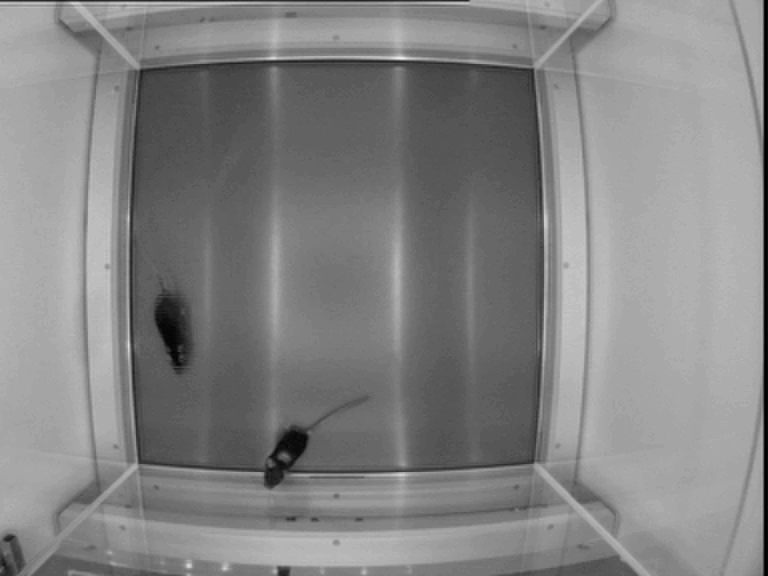

In [4]:
# or sliced to a particular frame:
show_frame_in_notebook(video_source[600][1])

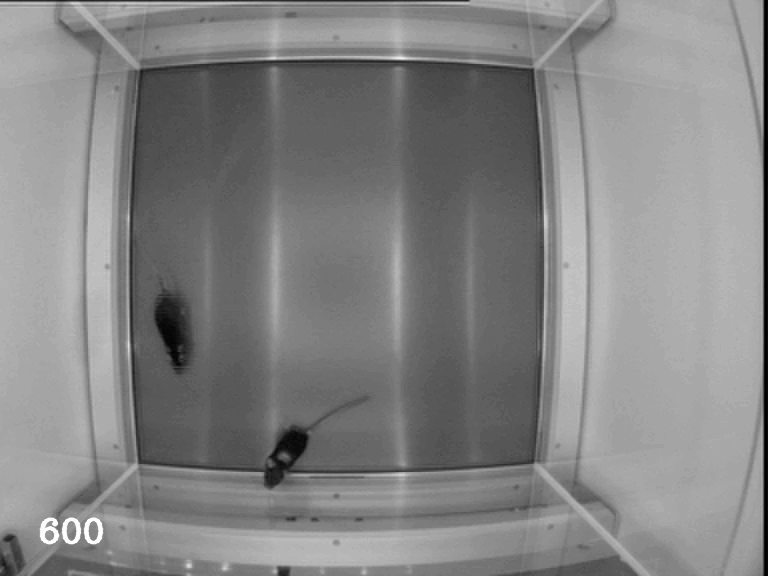

In [5]:
# we can also add a little text to mark the frame we got:
text_source = TextAnnotatedFramesGenerator(video_source, text_input=lambda x: dict(text=str(x)))

# the text_source here takes any other toolbox object as a frame source and adds its own modification (in this case a counter)
show_frame_in_notebook(text_source[600][1])

# for more options, check out the code!

In [6]:
# we can also add tracking
track0_source = KeypointInstanceAnnotatedFramesGenerator(text_source, track_df=track_df.loc["track_0"], skeleton_df=skeleton_df, 
                                                     color="red", alpha=0.2)

# but as this is implemented in Matplotlib, it is slow when evaluated
track1_source = KeypointInstanceAnnotatedFramesGenerator(track0_source, track_df=track_df.loc["track_1"], skeleton_df=skeleton_df, 
                                                     color="blue", alpha=0.2)

# in return for allowing usage of all matplotlib functions, with the underlying figure having the same resolution, and coordinate space, as the frame source

In [7]:
# evaluation happens during slicing, displaying, or writing
extracted_frames = track1_source[500:750]

In [8]:
# we can write either to a file
write_frame_source_to_gif(r"output\annotated_example.gif", extracted_frames, fps_override=video_source.fps, show_progress=True)

  0%|          | 0/251 [00:00<?, ?it/s]

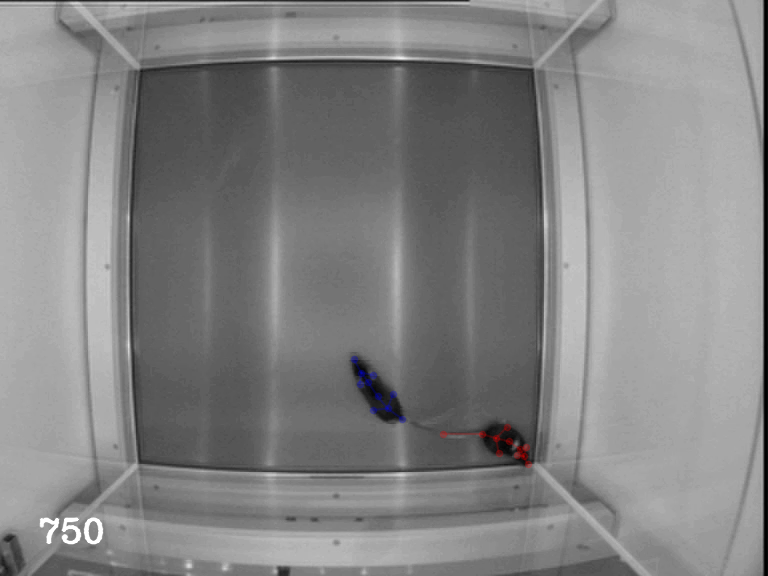

  0%|          | 0/251 [00:00<?, ?it/s]

In [9]:
# or display in a notebook
show_frame_source_in_jupyter_notebook(extracted_frames)

In [10]:
from behavioral_analysis.frame_pipeline.cv2_classes import KeypointInstanceAnnotatedFramesGenerator

cv2_track0_source = KeypointInstanceAnnotatedFramesGenerator(text_source, track_df=track_df.loc["track_0"], skeleton_df=skeleton_df, 
                                                     color=(255, 0, 0), alpha=1)
cv2_track1_source = KeypointInstanceAnnotatedFramesGenerator(cv2_track0_source, track_df=track_df.loc["track_1"], skeleton_df=skeleton_df, 
                                                     color=(0, 0, 255), alpha=1)

In [ ]:
# As comparison, CV2 plotting is about twice as fast, and about thrice if using alpha=1
cv2_extracted_frames = cv2_track1_source[500:750]

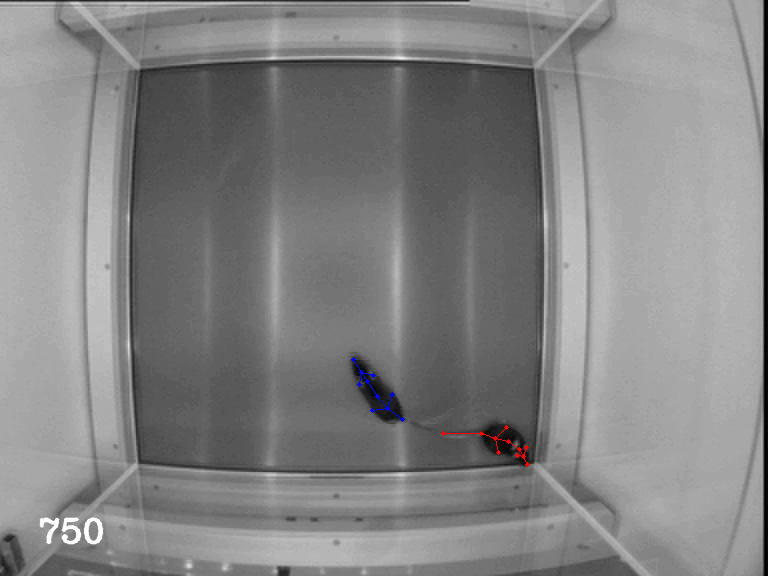

  0%|          | 0/251 [00:00<?, ?it/s]

In [12]:
show_frame_source_in_jupyter_notebook(cv2_extracted_frames)

In [13]:
# other modifications are also possible
# here based on cv2, so a lot faster, but a bit more limited
import cv2

def _blur_frame_using_cv2(frame, **kwargs):
    input_kwargs = {**dict(ksize=9), **kwargs}
    return cv2.medianBlur(frame.copy(), **input_kwargs)

modified_frame_source = FuncModifiedFramesGenerator(extracted_frames, modification_func=_blur_frame_using_cv2, no_args_means_skip=False)
modified_frames = modified_frame_source[:]

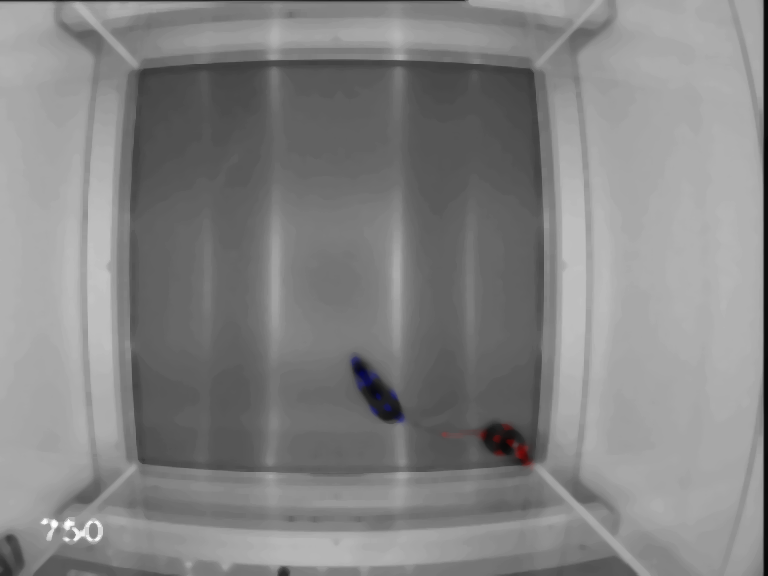

  0%|          | 0/251 [00:00<?, ?it/s]

In [14]:
show_frame_source_in_jupyter_notebook(modified_frames)

In [15]:
# frame manipulations such as slicing and rotating (through cv2 again)
track0_roi_df = roi_df.loc["track_0"].dropna(axis=0)
track0_orientation_series = orientation_series.loc["track_0"]
roi_source = FrameReorientedRoiExtractor(extracted_frames, roi_df=track0_roi_df, 
                                         orientation_series=track0_orientation_series, 
                                         target_orientation=0)
reoriented_frames = roi_source[:]

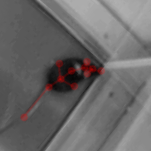

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
# Displaying also works with sliced videos
show_frame_source_in_jupyter_notebook(reoriented_frames[-10:])

In [17]:
# We can also feed evaluated (sliced) frames into other objects, and apply arbitrary functions
def _threshold_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
    return thresh

def _mark_contours_on_threshold(thresh):
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    color_thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
    marked_frame = cv2.drawContours(color_thresh, contours, -1, (0,255,255), 2)
    return marked_frame

def _mark_contours_on_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _ret,thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
    contours, _hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    marked_frame = cv2.drawContours(frame.copy(), contours, -1, (0,255,255), 2)
    return marked_frame

frame_stack = FrameStackReader(reoriented_frames)
thresh_source = FuncModifiedFramesGenerator(reoriented_frames, modification_func=_threshold_frame)
contour_thresh_source = FuncModifiedFramesGenerator(thresh_source, modification_func=_mark_contours_on_threshold)
contour_source = FuncModifiedFramesGenerator(reoriented_frames, modification_func=_mark_contours_on_frame)

In [18]:
# A merger object can be used to stitch the parallel frame streams back into one
merged_source = FrameSourceMerger([frame_stack, 
                                   thresh_source, contour_thresh_source, 
                                   contour_source], columns=2)

# necessary because PIL works with a different color format than cv2
color_fixed = FuncModifiedFramesGenerator(merged_source, modification_func=lambda frame: cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [19]:
write_frame_source_to_gif(r"output\merged_example.gif", merged_source, fps_override=video_source.fps, show_progress=True)

  0%|          | 0/251 [00:00<?, ?it/s]

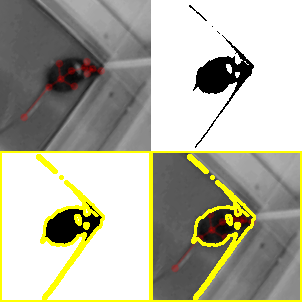

  0%|          | 0/251 [00:00<?, ?it/s]

In [20]:
# As shown here, all frames are returned as one merged image
show_frame_source_in_jupyter_notebook(merged_source)

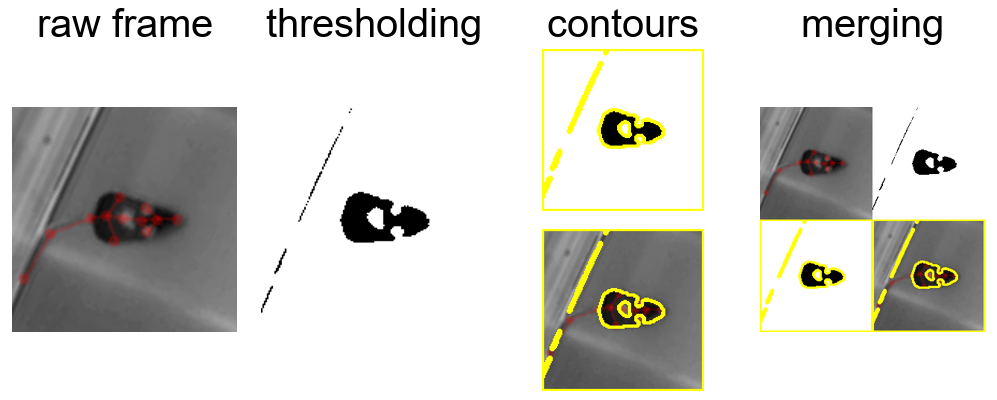

In [21]:
# for visualization purposes there is also a function to create an overview of the pipeline
pipeline_sequence = (frame_stack, thresh_source, [contour_thresh_source, contour_source], merged_source)
pipeline_overview = create_pipeline_overview(*pipeline_sequence, annotation_list=["raw frame", "thresholding", "contours", "merging"])
pipeline_overview.save(r"output\pipeline_overview.png")
pipeline_overview